# Predicting Voter Behavior
## CS109a Final Project


**Harvard University**<br/>
**Fall 2023**<br/>
**Students**: Aaron Berger, Anne Brandes, Alex Tonnelli<br/>

<hr style="height:2pt">

<a id="contents"></a>

## Table of Contents

- [**Problem Statement**](#problem-statement)

- [**Exploration and Visualization**](#Exploration-and-Visualization)

- [**Model Building and Evaluation**](#Model-Building-and-Evaluation)

- [**Single-Year Logistic Regression Model**](#Single-Year-Logistic-Regression-Model)

- [**Sliding Window Dataset Creation**](#Sliding-Window-Dataset-Creation)

- [**Logistic Regression**](#Logistic-Regression)

- [**Decision Tree**](#Decision-Tree)

- [**Random Forest**](#Random-Forest)

- [**AdaBoost**](#AdaBoost)
    - [**AdaBoost Base Depth Selection**](#AdaBoost-Base-Depth-Selection)
    - [**Final AdaBoost Model**](#Final-AdaBoost-Model)

- [**Future Work**](#Future-Work)

<a id="Problem-Statement"></a>

# Problem Statement

[Return to contents](#contents)

Predicting the voting behavior of a voter is of vital importance for political campaigns (and many other entities), for accurate targeting. However, current methods (to be discussed furthe in the final project submission) lack both generlizability and interpretability. In this project, we'll explore how voter demographics and past voting history indicate a voter's likelihood to vote in a given election, and how accurately understandable models can be built to predict this propensity.

Data is collected from an export of the Pennsylvania Full Voter File, which is publicly available and contains the voting history and demographics of all currently registered voters in the state. We will explore models' ability to both predict on some voters in a given election (having trained on other voters in the same election), and to predict on voters in an unseen election, where there are new unseen but very important features (past response variables which have now become election history for a voter). In this second case, we will use a sliding window approach to build a model which learns features that are relative to the response variable election, allowing for smooth generalization to new elections.

<a id="Exploration-and-Visualization"></a>

# Exploration and Visualization

[Return to contents](#contents)

Data from the raw voter file is first processed in `process_data.ipynb`. At a high level, that script does the following:
- Pre-processing
    - Gather the counties to use
    - Define the final demographic and election history features to use
    - Reformat data (one-hot encodings, scaling, etc.)
- Processing
    - Read in the raw data
    - Migrate the raw data to the global feature set
    - Write the data into parts
- Sampling
    - Sample the data to get a single file for EDA.

EDA and visualization is then run in the notebook `eda.ipynb`.

<a id="Model-Building-and-Evaluation"></a>

# Model Building and Evaluation

[Return to contents](#contents)

In this notebook, we'll use the processed voter data, along with the interpretation of the EDA, to build models to predict voter turnout.

In [26]:
import itertools
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from tqdm import tqdm

from config import (
    FEATURES_FILE,
    MAJOR_ELECTIONS_DATES_FILE,
    PROCESSED_DATA_DIR,
    SLIDING_WINDOW_FILE,
    TEN_PCT_SAMPLE_FILE,
    election_date_to_feature_names,
)

In [7]:
# Let's ignore warnings for better flow and visualization. We've ensured that any warnings printed are expected.
import warnings
warnings.filterwarnings("ignore")

For the purpose of this project, we will use the sample file to train and test models (since it would take too long and take too much RAM to train on the full dataset, given the likely only tiny improvement in performance). The next cell will take about 12 seconds to run.

In [8]:
df_single = pd.read_csv(TEN_PCT_SAMPLE_FILE)

# The original data is not shuffled, so we shuffle it here
df_single = shuffle(df_single, random_state=109)

df_single.head()

,DOB,Registration Date,Voter Status,Status Change Date,Date Last Changed,Gender M,Gender F,Gender U,Party D,Party R,...,Election 01/03/2006 Party R,Election 01/03/2006 Party I,Election 01/03/2006 Voted,Election 01/03/2006 By Mail,Election 09/09/2008 Presence,Election 09/09/2008 Party D,Election 09/09/2008 Party R,Election 09/09/2008 Party I,Election 09/09/2008 Voted,Election 09/09/2008 By Mail
367520,0.337,0.862,1,0.862,0.996,0,0,1,0,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
412394,0.669,0.832,1,0.870,0.996,1,0,0,0,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
842981,0.497,0.840,0,0.997,0.985,1,0,0,1,0,...,0.0,1.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN
725933,0.631,0.845,1,0.868,0.996,0,0,1,1,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
628919,0.558,0.781,1,0.889,0.992,1,0,0,0,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


<a id="Single-Year-Logistic-Regression-Model"></a>

# Single-Year Logistic Regression Model

[Return to contents](#contents)

First, we'll create a simple logistic regression model to predict voter turnout in a single election. We'll use the 2023 primary as our response variable, and use all other elections and demographics as features.

This simple model will serve as a baseline to compare accuracy scores. Since the features all align to specific election years (as compared to the sliding window approach described below), we also expect this accuracy to be significantly higher than other models: unlike models using the sliding window approach, this model will be able to learn features that are specific to the response variable election (how a certain election affects a certain year's outcome, rather than how an arbitrary election affects a certain year's outcome).

Note that we don't use cross validation for this model, since the size of the dataset would make it take too long to run. This model will take 15 seconds to impute values and 1-2 minutes to fit.

In [9]:
response_election_columns = [col for col in df_single.columns if '05/16/2023' in col]
response_column = 'Election 05/16/2023 Voted'

# Count the proportion of each class
df_single[response_column].value_counts(normalize=True)

Election 05/16/2023 Voted
0    0.755949
1    0.244051
Name: proportion, dtype: float64

It appears we have some class imbalance. However, SMOTE runs on the order of $n^2$ for $n$ samples, so that certainly won't be viable for this task (especially when we multiply the number of samples for the sliding window approach). We'll instead use class weights to account for the imbalance.

In [64]:
# Simple imputer
# NOTE: kNN imputation is preferred for this type of data, but it takes too long to run
imputer = SimpleImputer(strategy='mean')
imputer.fit(df_single)

print("Finished fitting imputer. Imputing missing values...")

df_single = pd.DataFrame(imputer.transform(df_single), columns=df_single.columns)

print("Finished imputing missing values. Fitting model...")

# We know (from below) that the response variable has no missing values
X = df_single.drop(response_election_columns, axis=1)
y = df_single[response_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=109)

print("Finished fitting model. Fitting model...")

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

Finished fitting imputer. Imputing missing values...
Finished imputing missing values. Fitting model...
Finished fitting model. Fitting model...


### Non-convergence

Note that the model above might not have converged perfectly (you may see a warning message). This is because there are a very large number of features and observations. However, allowing convergence increases the accuracy by only a tiny amount, so we've left it as-is to save time.

In [65]:
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean squared error: {mse:.2f}")

r2 = r2_score(y_val, y_val_pred)
print(f"R2 score: {r2:.2f}")

print(f"Accuracy score: {accuracy_score(y_val, y_val_pred):.4f}")

Mean squared error: 0.16
R2 score: 0.13
Accuracy score: 0.8394


This accuracy score is much higher than the expected accuracy of a voter turnout model (and better than the best reported accuracy for this task in the literature), since it is trained and tested on the same election. Thus, it is able to converge on features which are specific to one election (how does election $i$ contribute specifically to turnout in election $j$), rather than features which are relative to the response variable (how does the election $n$ years ago contribute to this election). Specifically, the 2020 general election likely contributed differently to the 2023 primary turnout than the 2019 general election, due to differences beyond their relative 2 year difference (which is all the sliding window model could learn): for example, COVID-19 occurred in this time period.

Thus, an 87% accuracy is reasonable, since this model is not generalizable to new elections. Below, we'll explore a model which is.

Next, let's take a look at the ROC curve and confusion matrix for this model. We'll define a function to plot these, since we'll use this function for all our models for comparison.

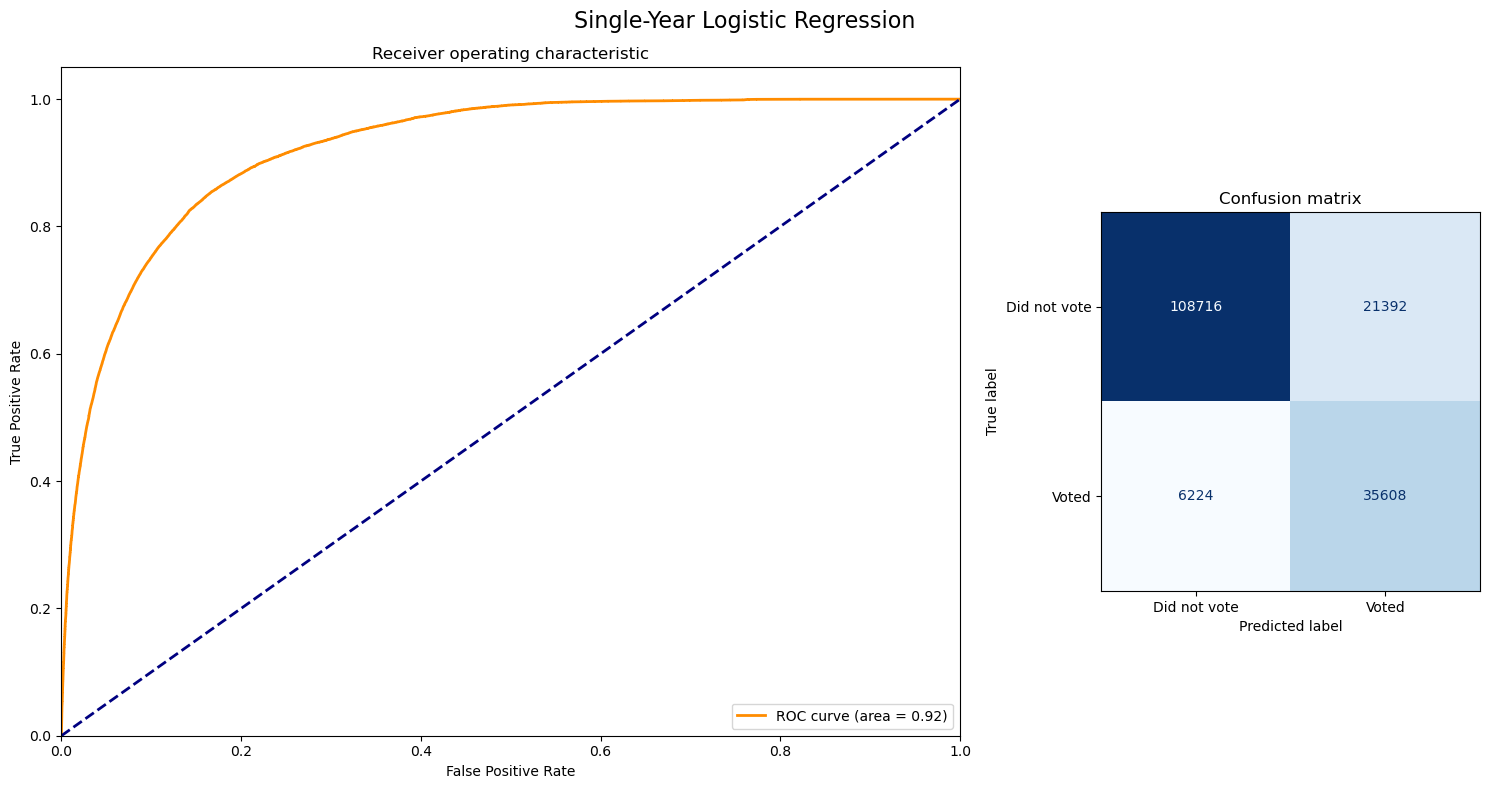

In [12]:
def plot_roc_and_confusion_matrix(X_val, y_val, y_pred, model, model_name):
    y_scores = model.predict_proba(X_val)[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(15, 8))
    grid = plt.GridSpec(1, 3)

    ax0 = fig.add_subplot(grid[0, :2])
    lw = 2
    ax0.plot(fpr, tpr, color="darkorange", lw=lw, label=f"ROC curve (area = {roc_auc:.2f})")
    ax0.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    ax0.set_xlim([0.0, 1.0])
    ax0.set_ylim([0.0, 1.05])
    ax0.set_xlabel("False Positive Rate")
    ax0.set_ylabel("True Positive Rate")
    ax0.set_title("Receiver operating characteristic")
    ax0.legend(loc="lower right")

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_val, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    ax1 = fig.add_subplot(grid[0, 2])
    ax1.set_title("Confusion matrix")
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=["Did not vote", "Voted"])
    disp.plot(ax=ax1, cmap=plt.cm.Blues, values_format="d")
    ax1.get_images()[0].colorbar.remove()

    plt.suptitle(model_name, fontsize=16)

    plt.tight_layout()
    plt.show()

plot_roc_and_confusion_matrix(X_val, y_val, y_val_pred, model, "Single-Year Logistic Regression")

The ROC curve looks as expected, with no irregularities. The confusion matrix shows that the model has fewer false negatives than false positives, which is good for our purposes: in usage of this model, we'd rather predict that a voter who won't end up voting votes than missing a true voter.

<a id="Sliding-Window-Dataset-Creation"></a>

# Sliding Window Dataset Creation

[Return to contents](#contents)

Next, we need to create a sliding window dataset, where each sample is a continuous subset of one voter's election features, such that a model can learn to predict differing elections as the response variable. First, let's figure out which elections we have sufficient data for (for a sliding window approach, high feature presence will be important, since imputation on election features that are only relative in time may lead to weird model behavior).

**This cell takes a long time to run, but isn't necessary to run for the rest of the notebook. The results are shown below the cell and are sufficient to understand the rest of the notebook.**
The cell takes about 2 minutes to run.

In [6]:
# Find the percent of all samples which have each election date

major_elections = json.load(open(MAJOR_ELECTIONS_DATES_FILE))["dates"]

num_total = 0
num_sampled = [0] * len(major_elections)

for file in tqdm(
    os.listdir(PROCESSED_DATA_DIR), desc="Reading files", unit="file", colour="green"
):
    if file.endswith(".csv"):
        if file == TEN_PCT_SAMPLE_FILE:
            continue
        else:
            df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, file))

            num_total += len(df)

            for date in major_elections:
                presence_column = f"Election {date} Presence"

                if presence_column in df.columns:
                    num_sampled[major_elections.index(date)] += df[presence_column].sum()

for i in range(len(major_elections)):
    print(f"Election date {major_elections[i]} has {num_sampled[i]} samples, {num_sampled[i] / num_total * 100:.2f}% existence")

Reading files: 100%|██████████| 70/70 [01:51<00:00,  1.60s/file]

Election date 11/04/2003 has 1852105 samples, 19.60% existence
Election date 04/27/2004 has 3428863 samples, 36.29% existence
Election date 11/02/2004 has 4476074 samples, 47.37% existence
Election date 05/17/2005 has 6627217 samples, 70.14% existence
Election date 11/08/2005 has 7305457 samples, 77.32% existence
Election date 05/16/2006 has 7335460 samples, 77.64% existence
Election date 11/07/2006 has 7335460 samples, 77.64% existence
Election date 05/15/2007 has 8463617 samples, 89.58% existence
Election date 11/06/2007 has 8463617 samples, 89.58% existence
Election date 04/22/2008 has 9448494 samples, 100.00% existence
Election date 11/04/2008 has 9448494 samples, 100.00% existence
Election date 05/19/2009 has 9448494 samples, 100.00% existence
Election date 11/03/2009 has 9448494 samples, 100.00% existence
Election date 05/18/2010 has 9448494 samples, 100.00% existence
Election date 11/02/2010 has 9448494 samples, 100.00% existence
Election date 05/17/2011 has 9448494 samples, 100

We can see that all elections since the primary in 2008 have 100% feature presence. Thus, we can built a sliding window dataset with no needed imputation by using only these election years. So, we're left with 30 elections, for which we'll use 10 sliding windows of 20 features (10 years) and1 response variable each.

Optimally, we would sample the full dataset on each sliding window (thus, a 100% sample), but this would result in about 100,000,000 samples (10 sliding windows $\times$ 10,000,000 voters). To balance computational cost, we'll sample 10% of the data for now, which will result in about 10,000,000 samples.

In [13]:
feature_election_dates = json.load(open(MAJOR_ELECTIONS_DATES_FILE))["feature_dates"]

demographic_features = json.load(open(FEATURES_FILE))["demographic"]

# Allow for 10 years of election history and 1 response variable election
SLIDING_WINDOW_LENGTH = 21
num_sliding_windows = len(feature_election_dates) - SLIDING_WINDOW_LENGTH + 1

# Use the election names "T - 1", "T - 2", etc. for the feature elections
# However, we've decided to only use elections which have 100% presence, so "Presence" columns are redundant
sliding_election_column_names = list(
    itertools.chain.from_iterable(
        [
            [feat for feat in election_date_to_feature_names(f"T-{i}") if "Presence" not in feat]
            for i in range(SLIDING_WINDOW_LENGTH - 1, 0, -1)
        ]
    )
)

# Remove the features which would cause leakage in the sliding window approach
sliding_demographic_features = [feature for feature in demographic_features if "Gender" in feature]

sliding_features = sliding_demographic_features + sliding_election_column_names + ["Response"]

df = pd.DataFrame(columns=sliding_features)

Above, we've removed some demographic features for this sliding window approach for simplicity. For example, `Registration Date`, `Last Vote Date`, etc. have been removed, and most importantly, `DOB` has been removed. For all these features, including them would require that, for each sample, we re-calculate their value, since they are dates or ages. For `DOB`, the age of the voter would need to be adjusted for each election year. For this version, we have left this out in the interest of testing general model ability on this data.

This cell takes about 3-4 minutes to run.

In [4]:
dfs = []

# Now, read in the data and sample for each sliding window
for i, file in enumerate(tqdm(
    os.listdir(PROCESSED_DATA_DIR), desc="Reading files", unit="file", colour="green"
)):
    if file.endswith(".csv"):
        if file == TEN_PCT_SAMPLE_FILE:
            continue
        else:
            df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, file))

            # Sample each sliding window
            for i in range(num_sliding_windows):
                # Gather the election features for the current sliding window
                election_columns = list(
                    itertools.chain.from_iterable(
                        [feat for feat in election_date_to_feature_names(date) if "Presence" not in feat]
                        for date in feature_election_dates[i : i + SLIDING_WINDOW_LENGTH - 1]
                    )
                )

                # Gather the response variable election for the current sliding window
                response_column = f"Election {feature_election_dates[i + SLIDING_WINDOW_LENGTH - 1]} Voted"

                all_selected_columns = sliding_demographic_features + election_columns + [response_column]

                # Sample the data
                df_sample = df[all_selected_columns].sample(frac=0.01)
                df_sample.columns = sliding_features

                dfs.append(df_sample)

df = pd.concat(dfs)
df.to_csv(SLIDING_WINDOW_FILE, index=False)

Reading files: 100%|██████████| 71/71 [03:38<00:00,  3.07s/file]


Note that there is still some bias introduced which we cannot overcome, from voters which have been eliminated from the file since the response election date. Those voters may have died or moved, but we'd like our model to still learn from them. The only solution to this is to request the voter files from those dates, but this would (for us) be too time-consuming and expensive.

In [56]:
# NOTE: If you'd like to resume this notebook without running the above cell, simply read in the saved file
df = pd.read_csv(SLIDING_WINDOW_FILE)

response_variable_column = "Response"

X = df.drop(response_variable_column, axis=1)
y = df[response_variable_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=109)

<a id="Logistic-Regression"></a>

# Logistic Regression

[Return to contents](#contents)

Let's build our first model on this sliding window dataset. For comparison against the single-year logistic regression model, we'll train another logistic regression model on this dataset.

This model will take about 2 minutes to fit.

In [62]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

In [35]:
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean squared error: {mse:.2f}")

r2 = r2_score(y_val, y_val_pred)
print(f"R2 score: {r2:.2f}")

print(f"Accuracy score: {accuracy_score(y_val, y_val_pred):.4f}")

Mean squared error: 0.18
R2 score: 0.21
Accuracy score: 0.8194


We can see a slight decrease in performance from the single-year OLS model. This is expected, since the sliding window model is learning features which are relative to the response variable election, rather than features which are specific to the response variable election. Thus, the sliding window model is learning features which are more generalizable to new elections, but are less accurate for the specific response variable election.

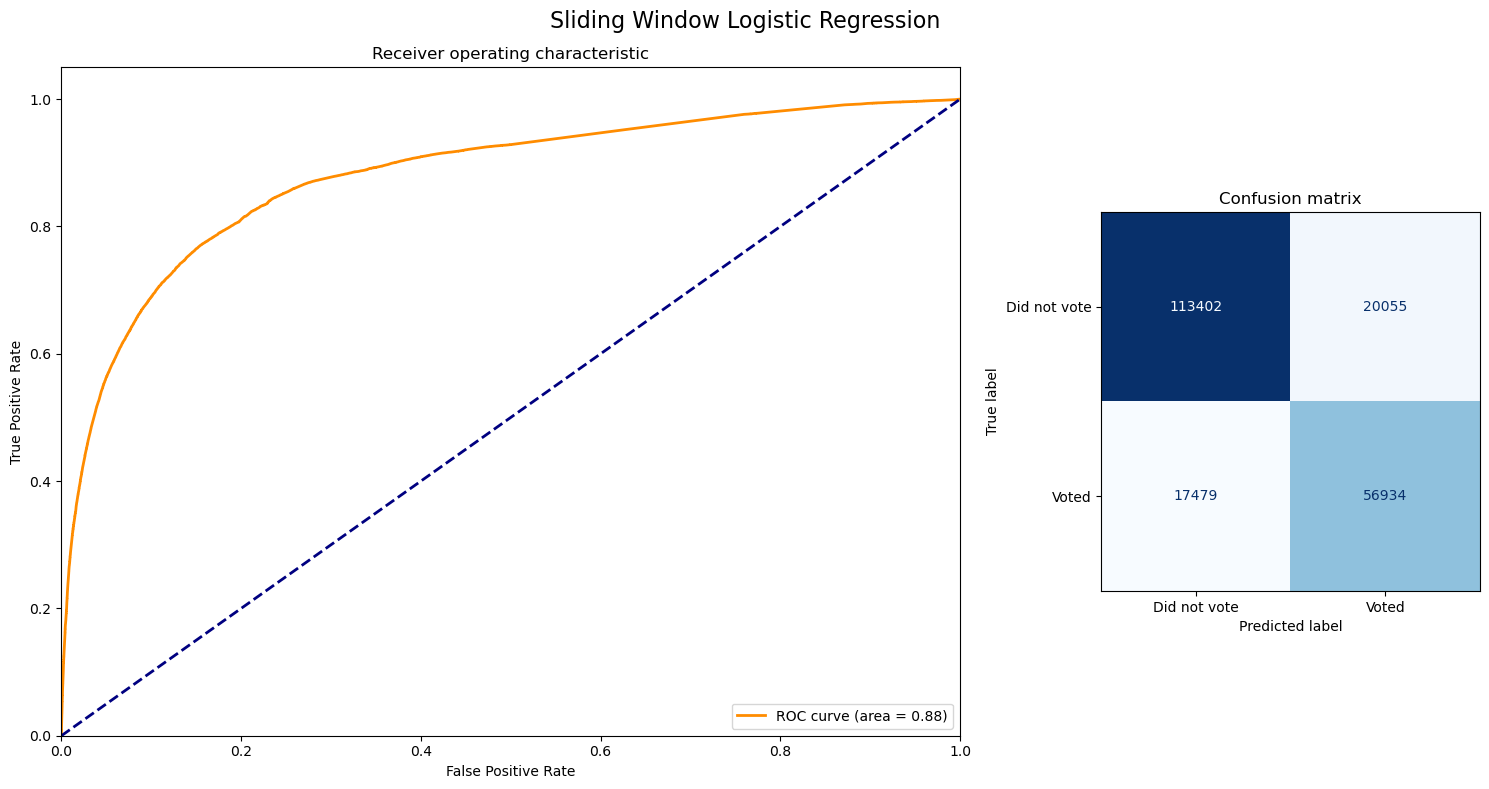

In [16]:
plot_roc_and_confusion_matrix(X_val, y_val, y_val_pred, model, "Sliding Window Logistic Regression")

The ROC curve similarly looks as expected, with a slightly less steep curve on the right side of the graph as compared to the single-year model. This is likely due to the fact that the sliding window model is learning features which are more generalizable to new elections, but are less accurate for the specific response variable election. The confusion matrix also shows the similar trend of more false positives than false negatives, but the difference is less pronounced than in the single-year model.

<a id="Decision-Tree"></a>

# Decision Tree

[Return to contents](#contents)

The logistic regression model has decent accuracy, but it may not be able to learn the complex relationships between the features and the response variable. Next, we'll try a decision tree model, which can learn more complex relationships on very large datasets, by splitting into branches (which can model specific common cases).

For example, perhaps if a voter voted in a certain election, then some other 5 elections nearly perfectly predicts whether they will vote in the response election, whereas if they didn't vote in that election, then some other 5 elections nearly perfectly predicts whether they will vote in the response election. A decision tree can learn this relationship, whereas a logistic regression model cannot.

In [17]:
# In case the above cell is not run, read in the data from the file
try:
    df
except NameError:
    df = pd.read_csv(SLIDING_WINDOW_FILE)

# Initializing the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=109, class_weight='balanced')

# Training the model
dt_classifier.fit(X_train, y_train)

# Predicting on the validation set
y_val_pred = dt_classifier.predict(X_val)

# Evaluating the model
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

In [18]:
print(f"The model's accuracy is {accuracy * 100:.2f}%\n")
print(report)

The model's accuracy is 79.81%

              precision    recall  f1-score   support

           0       0.84      0.84      0.84    133457
           1       0.72      0.72      0.72     74413

    accuracy                           0.80    207870
   macro avg       0.78      0.78      0.78    207870
weighted avg       0.80      0.80      0.80    207870



We may have been incorrect in guessing the Decision Tree model would out-perform basic logistic regression. The accuracy is worse, but let's make an ROC curve, so we can visualize the model's performance across varying thresholds.

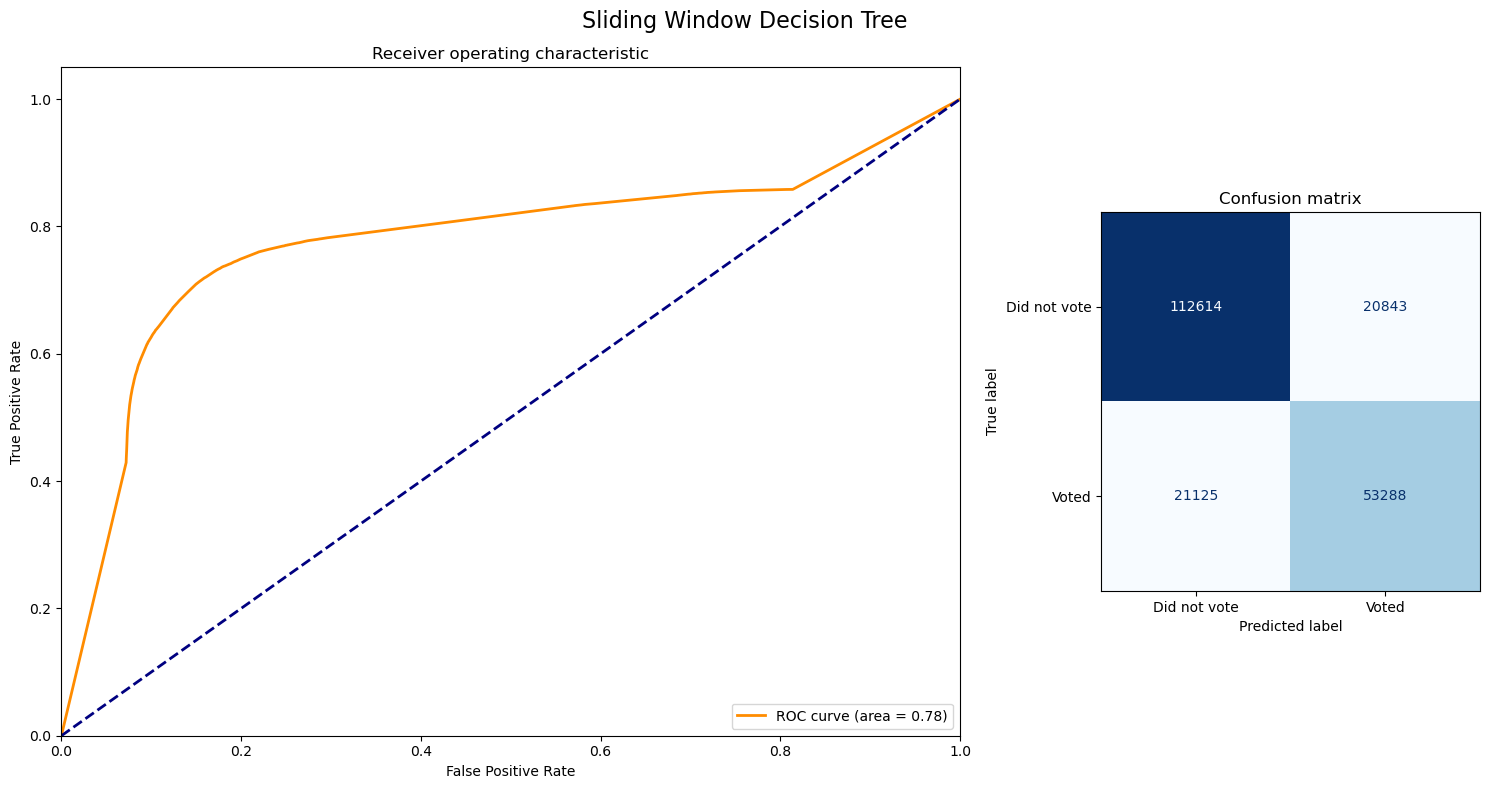

In [19]:
plot_roc_and_confusion_matrix(X_val, y_val, y_val_pred, dt_classifier, "Sliding Window Decision Tree")

Note the strange shape of the ROC curve. This is likely due to the "architecture" of a decision tree: an individual feature can cause massive jumps in the true positive rate with very little increase in the false positive rate (like that seen on the bottom left of this curve). This could be a very consequential election. This trend holds for very irregular curves in the other direction too, shown on the right.

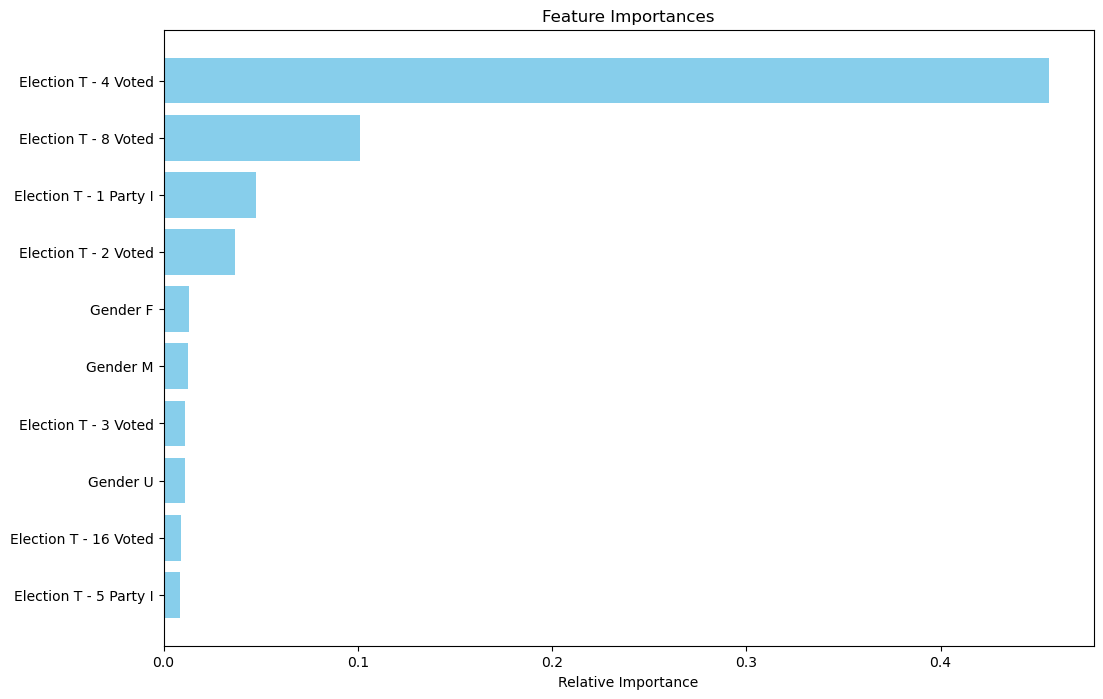

In [20]:
# Get feature importances from the decision tree model
feature_importances = dt_classifier.feature_importances_

# Create a DataFrame to hold the feature names and their importance scores
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(features_df['Feature'][:10], features_df['Importance'][:10], color='skyblue')
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()
plt.show()

As expected, the best predictors of turnout in an election are the most recent similar elections. In this case, the best predictor was by far the election 2 years ago (`T-4`). For example, for a major presidential election (which only occurs every 4 years), the best predictor is the major general election 2 years ago, which has major statewide races. The next best predictor is the election 4 years ago (`T-4`), which is of the exact same type (with the same type of races). Further, the fourth best predictor is the election from 2 years ago, which is of the same type (primary or general), but may be a slightly different type (large statewide races instead of national presidential ones). This is a good sign that the model is learning the correct features.

A voter's one-hot Independent party registration is the 3rd best predictor of an election. This is likely because Independents cannot vote in primaries, and thus this feature is a perfect predictor for some elections. However, due to the sliding window approach, this feature does not apply the same to every election. In the next version, we'll attempt to address this concern, likely by adding a feature which indicates whether the response variable election is a primary or general election.

After this, the gender of the voter and random other election years are the next best elections, indicating most of the decision-making is coming from these first few features.

<a id="Random-Forest"></a>

# Random Forest

[Return to contents](#contents)

The decision tree allowed us to build some good interpretations of the data, and provided a baseline for tree-based models. However, it didn't outperform basic logistic regression, so we'll try another model. Random forest models can be more accurate than decision trees, but at the cost of being more difficult to interpret.

In [21]:
# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# Training the model
rf_classifier.fit(X_train, y_train)

# Predicting on the validation set
y_val_pred = rf_classifier.predict(X_val)

# Evaluating the model
accuracy_rf = accuracy_score(y_val, y_val_pred)
report_rf = classification_report(y_val, y_val_pred)

In [22]:
print(f"The model's accuracy is {accuracy_rf * 100:.2f}%\n")
print(report_rf)

The model's accuracy is 81.77%

              precision    recall  f1-score   support

           0       0.86      0.86      0.86    133457
           1       0.74      0.75      0.75     74413

    accuracy                           0.82    207870
   macro avg       0.80      0.80      0.80    207870
weighted avg       0.82      0.82      0.82    207870



This model performs slightly better than the decision tree, with an accuracy of 82% at a threshold of 0.5.

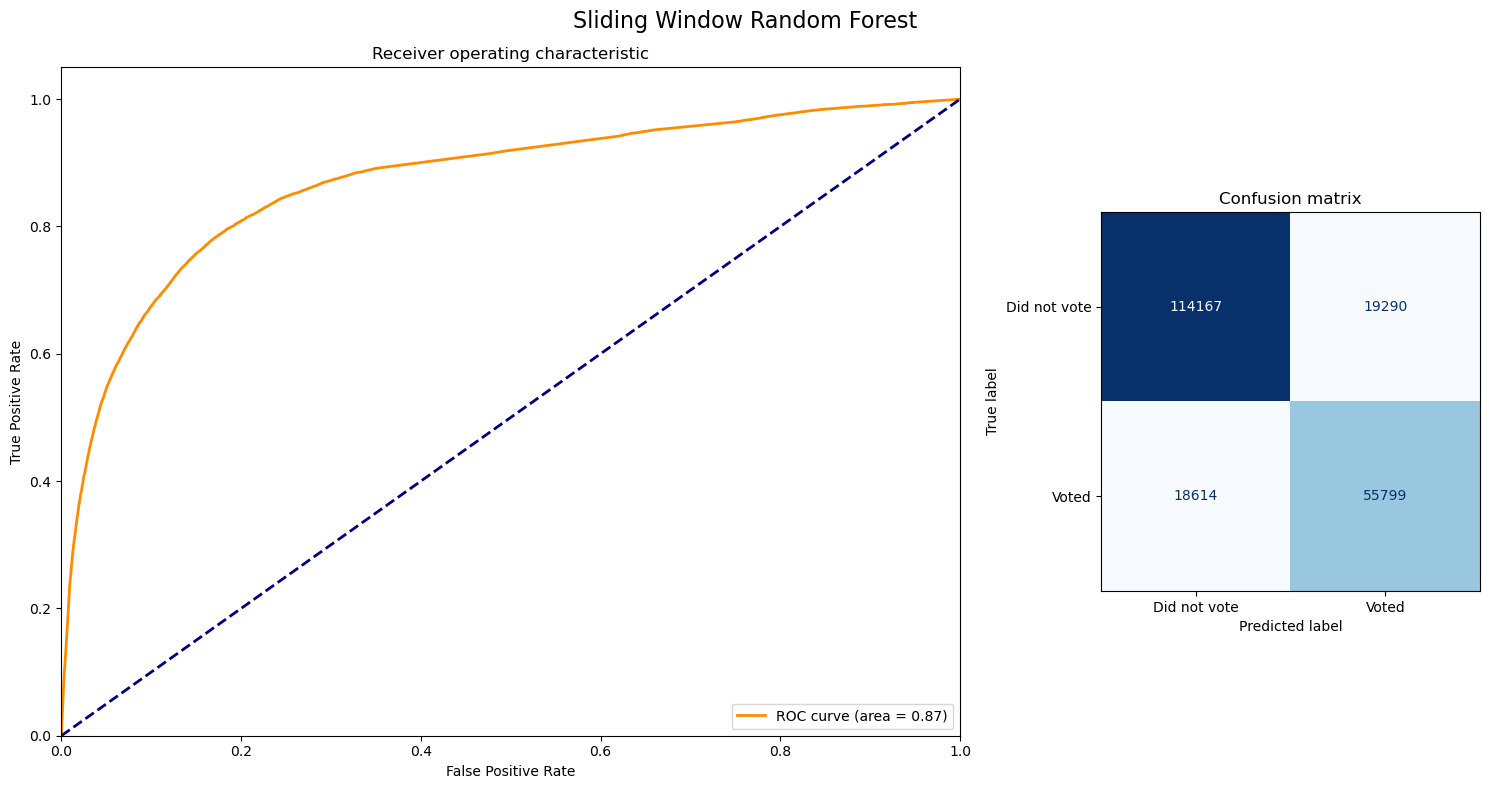

In [23]:
plot_roc_and_confusion_matrix(X_val, y_val, y_val_pred, rf_classifier, "Sliding Window Random Forest")

As expected, the accuracy is higher than that of the decision tree, but still not quite as high as the logistic regression model. Thus, it seems that tree-based models can perform similarly to logistic regression models, but we haven't yet found a model which outperforms logistic regression. We also tested with a higher number of estimators in the random forest (ommitted here, since those runs take a very long time), but the accuracy did not improve substantially.

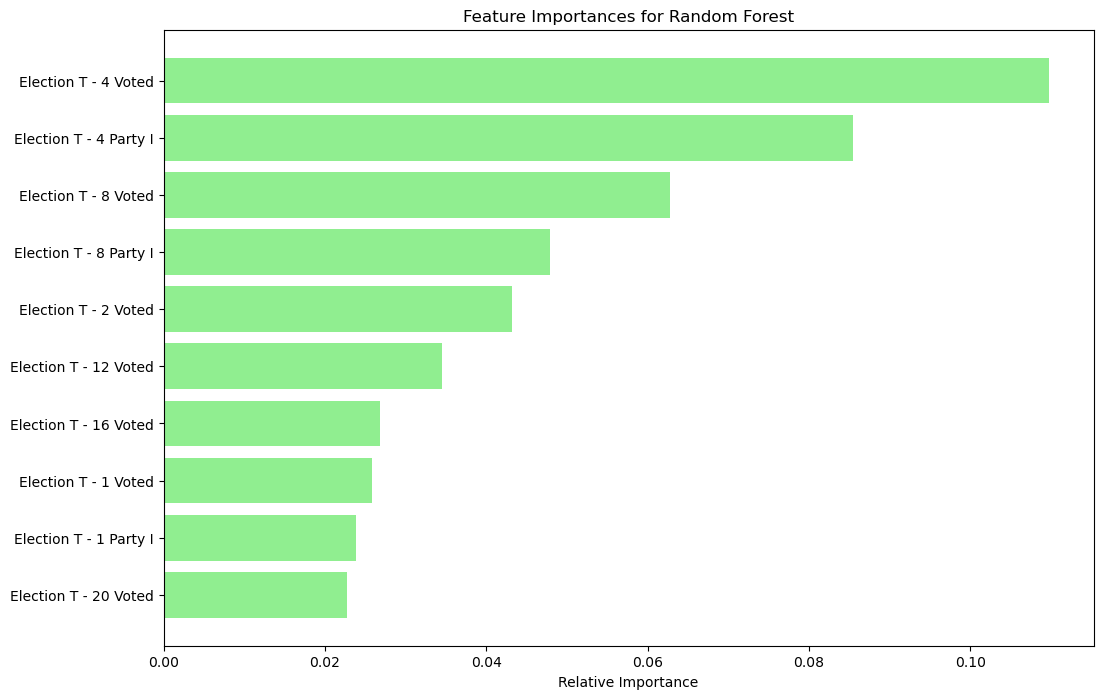

In [24]:
# Get feature importances from the random forest model
feature_importances_rf = rf_classifier.feature_importances_

# Create a DataFrame to hold the feature names and their importance scores for the random forest model
features_df_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rf})

# Sort the DataFrame by importance in descending order
features_df_rf = features_df_rf.sort_values(by='Importance', ascending=False)

# Plotting the feature importances for the random forest model
plt.figure(figsize=(12, 8))
plt.title('Feature Importances for Random Forest')
plt.barh(features_df_rf['Feature'][:10], features_df_rf['Importance'][:10], color='lightgreen')
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis() 
plt.show()

As expected, the random forest model has a much more even distribution of feature importance. Still, the elections from 2 years ago and 4 years ago are in the top 3 features, indicating that the model is learning the correct features. Here, the voter's Independent one-hot feature is the second-most important feature, likely for the same reason as above.

<a id="AdaBoost"></a>

# Boosting (AdaBoost)

[Return to contents](#contents)

Lastly, we'll try a boosting model, which can be very high-performance and accurate. We'll use AdaBoost, which is a boosting model which weights on each point to focus on previously misclassified points.

First, let's take an initial guess of depth-3 base estimators. Unfortunately, this takes a long time to run, since AdaBoost cannot be parallelized (due to its reliance on past estimators to weight the current estimator). So, we'll take a small sample of the data for model selection purposes, and then run the final AdaBoost model on the full dataset.

In [30]:
# Take a 10% sample of the data
try:
    df
except NameError:
    df = pd.read_csv(SLIDING_WINDOW_FILE)

df_sample = df.sample(frac=0.1)

X_sampled = df_sample.drop(response_variable_column, axis=1)
y_sampled = df_sample[response_variable_column]

X_sampled_train, X_sampled_val, y_sampled_train, y_sampled_val = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=109)

In [44]:
ada_boost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    learning_rate=0.1,
    algorithm="SAMME.R",
    n_estimators=800,
    random_state=109,
).fit(X_sampled_train, y_sampled_train)

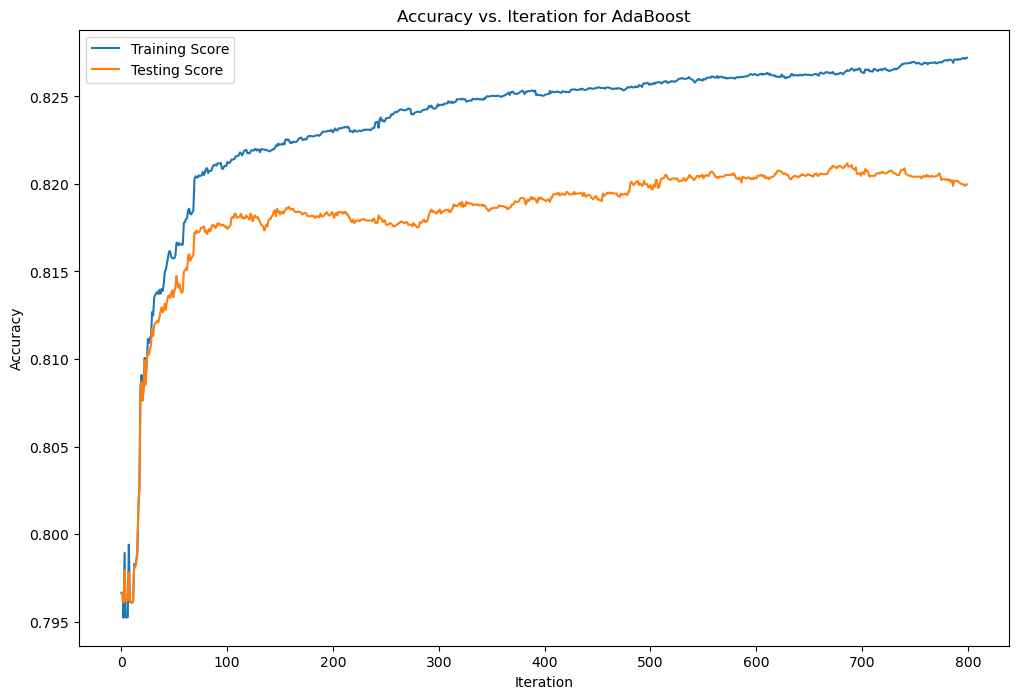

In [45]:
iteration_scores_train = list(ada_boost.staged_score(X_sampled_train, y_sampled_train))
iteration_scores_val = list(ada_boost.staged_score(X_sampled_val, y_sampled_val))

plt.figure(figsize=(12, 8))
plt.plot(iteration_scores_train, label="Training Score")
plt.plot(iteration_scores_val, label="Validation Score")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Iteration for AdaBoost")
plt.legend()
plt.show()

In [46]:
# Print the accuracy score for the AdaBoost model
print(f"Accuracy score: {accuracy_score(y_sampled_val, ada_boost.predict(X_sampled_val)):.4f}")

Accuracy score: 0.8200


Already, it appears as though the boosting model with base estimator depth 3 is performing better than the other best model (logistic regression). Let's test on base estimators of depth up to 4 to see if we can improve performance.

<a id="AdaBoost-Base-Depth-Selection"></a>

### AdaBoost Base Depth Selection

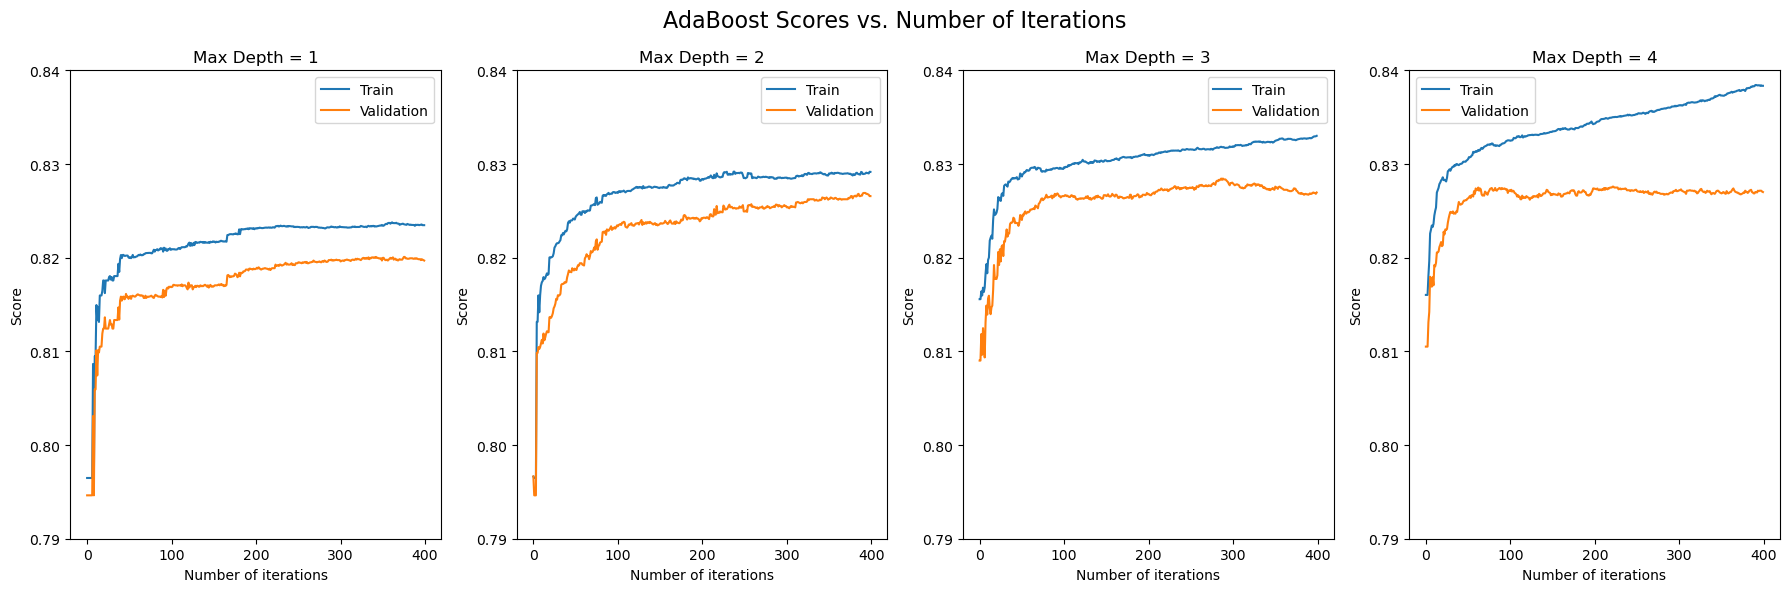

In [50]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

classifiers: dict[int, AdaBoostClassifier] = {}
val_scores: dict[int, list[float]] = {}

for i, depth in enumerate([1, 2, 3, 4]):
    ada_boost = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth),
        learning_rate=0.1,
        algorithm="SAMME.R",
        n_estimators=400,
        random_state=109
    ).fit(X_sampled_train, y_sampled_train)

    classifiers[depth] = ada_boost

    iteration_scores_train = list(ada_boost.staged_score(X_sampled_train, y_sampled_train))
    iteration_scores_val = list(ada_boost.staged_score(X_sampled_val, y_sampled_val))

    val_scores[depth] = iteration_scores_val
    
    # Plot the scores as a function of the number of iterations
    axes[i].plot(iteration_scores_train, label="Train")
    axes[i].plot(iteration_scores_val, label="Validation")
    axes[i].set_title(f"Max Depth = {depth}")
    axes[i].set_xlabel("Number of iterations")
    axes[i].set_ylabel("Score")
    
    # These were hard-coded to make the plots look nicer after running it once.
    axes[i].set_ylim(0.79, 0.84)
    axes[i].legend()

plt.suptitle("AdaBoost Scores vs. Number of Iterations", fontsize=16)
plt.tight_layout()

In [51]:
max_val_scores = [max(scores) for scores in val_scores.values()]
max_val_score = max(max_val_scores)
best_max_depth = list(val_scores.keys())[max_val_scores.index(max_val_score)]

num_iterations = val_scores[best_max_depth].index(max_val_score)

print(
    f"The maximum validation score of {max_val_score:.4f} is achieved "
    f"using {num_iterations} iterations and a max depth of {best_max_depth}."
)

The maximum validation score of 0.8285 is achieved using 286 iterations.


<a id="Final-AdaBoost-Model"></a>

### Final AdaBoost Model

We've found the best AdaBoost model, with a validation score of almost 83%. Let's re-train this model on the full dataset (with about 300 iterations), and see how it performs.

In [60]:
final_ada_boost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=best_max_depth),
    learning_rate=0.1,
    algorithm="SAMME.R",
    n_estimators=300,
    random_state=109,
).fit(X_train, y_train)

# Print the accuracy score for the AdaBoost model
print(f"Accuracy score: {accuracy_score(y_val, final_ada_boost.predict(X_val)):.4f}")

Accuracy score: 0.8311


We've managed to achieve an accuracy of 83.11% on the full dataset, which is the best accuracy we've seen so far. This is likely due to the fact that AdaBoost is able to learn the complex relationships between the features and the response variable, which the other models were not able to learn.

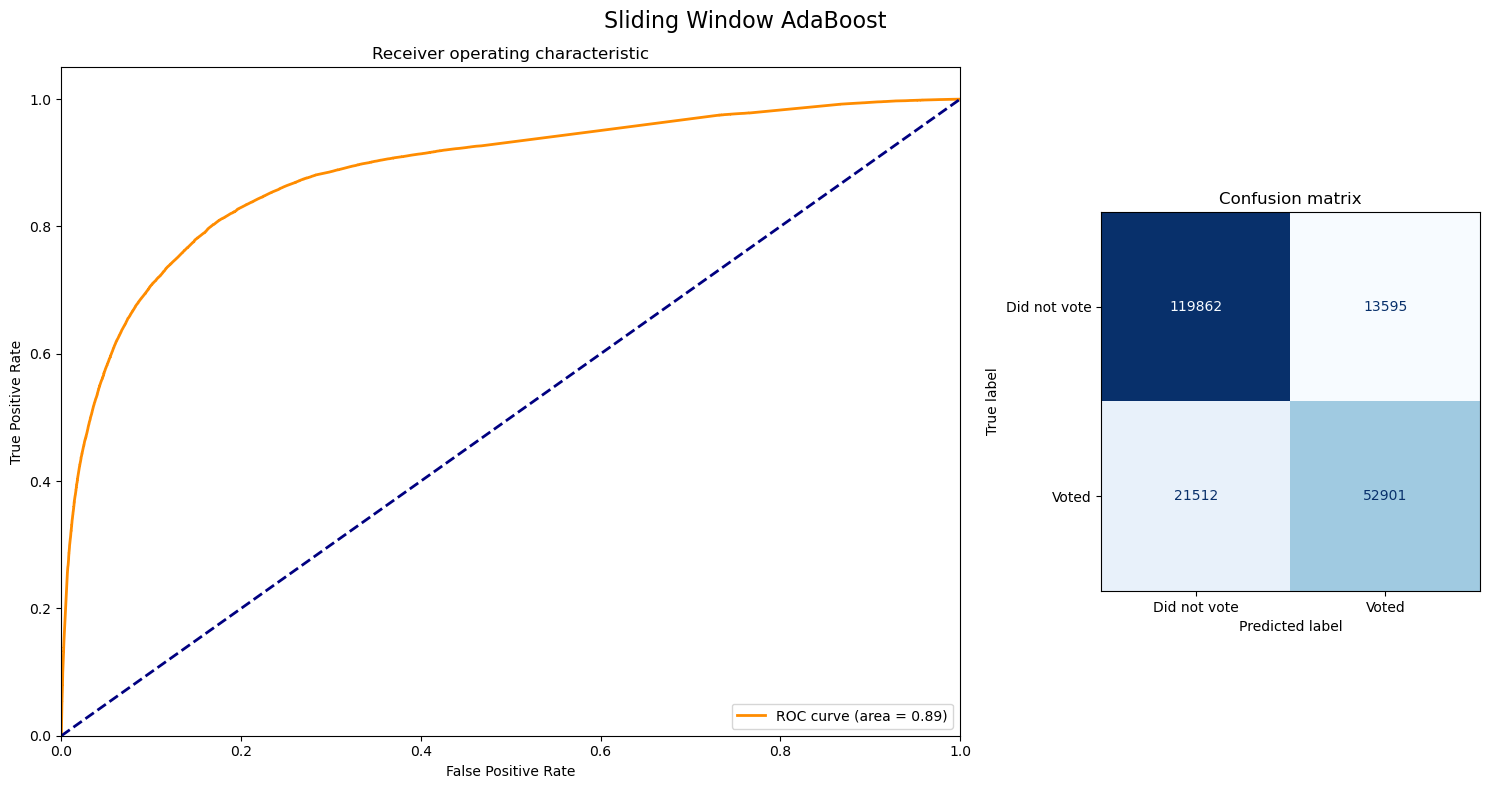

In [61]:
plot_roc_and_confusion_matrix(X_val, y_val, final_ada_boost.predict(X_val), final_ada_boost, "Sliding Window AdaBoost")

We can see that this is also the highest AUC score we've seen so far, at 0.89 (lower than the 0.92 AUC score for the single-year logistic regression model, but that model is not generalizable to new elections). Thus, we get the following comparison between all models we've trained, based on testing accuracy:

| model | test accuracy |
| --- | --- |
| single-year logistic regression | 83.94% |
| sliding window logistic regression | 81.94% |
| decision tree | 79.81% |
| random forest | 81.77% |
| AdaBoost | 83.11% |

We thus claim that an AdaBoost classifier with 300 estimators and a base estimator depth of 3 is the best model for this task. This model is able to learn the complex relationships between the features and the response variable, and is able to generalize to new elections.

<a id="Future-Work"></a>

# Future Work

[Return to contents](#contents)

In the future (past the scope of this project), we'd like to explore the following:

### Incorporate more features
By adding more features to the dataset outside the public voter files—like income, education, etc.—we may be able to increase the accuracy of the model. However, this would require a lot of work to gather the data, and would likely be expensive.

### Social links
It is very likely that a person's likelihood to vote can be more accurately guessed by looking at their family members' likelihoods to vote. Somehow linking members of the same household (if they live in the same address or have the same last name) may increase the accuracy of the model.

### Temporal models
We could try models which are built for temporal data. This may solve the sliding window problem, wherein we must use a model which can't learn specific features for each election date and rather must learn features which are relative to the response variable election.

### More computation
By increasing the computation available, we could upgrade the following. In this version, we ommitted these to save time:
    - Use kNN imputation instead of mean imputation, which makes more sense for this dataset (voters which are very alike are likely to have similar features).
    - Use cross-validation for the single-year logistic regression model, which would likely increase accuracy.
    - Use cross-validation for the sliding window logistic regression model, which would likely increase accuracy.
    - Use a larger sample of the full data, or use the full data, which may increase accuracy.